### Neshyba 2023


# Harmonic Oscillator

### Hamiltonian of a vibrating diatomic molecule

The Schrödinger equation of a vibrating diatomic molecule looks like the usual 

$$
H\psi=E\psi \ \ \ \ (1)
$$

where $H=-{\hbar^2 \over 2\mu} \nabla^2+V(x)$. We'll be solving this equation by diagonalizing the matrix form of $H$, in the position representation, in more or less the same way we did previously. Some differences:

### Potential energy
The *potential energy* part of the Hamiltonian will be given by

$$
V(x) = {1 \over 2}kx^2 \ \ \ \ (2)
$$

where $x$ is the displacement from the bond's equilibrium value: $x>0$ means we're stretching the bond, $x<0$ means we're compressing it. As for $k$ (the *force constant* of the bond), literature values are available in Herschbach and Laurie, 1961 (https://www.osti.gov/biblio/4837972/); see their *Table II, Quadratic, Cubic, and Quartic Vibrational Force Constants for Diatomic Molecules* (starting on II-2, about 2/3 of the way through the document). Units they use for $F_2$ are given on their page 4.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/Herschbach and Laurie.jpg" height="500" width="500"/>
<strong>Figure 1</strong>. Page from Herschbach and Laurie, 1961.<sup>TM</sup>. 
</p>

As previously, when constructing the Hamiltonian matrix in the position representation, $V(x)$ would appear on the diagonal. 

### Kinetic energy
The *kinetic energy* part of the Hamiltonian, given by

$$
-{\hbar^2 \over 2\mu} \nabla^2 \ \ \ \ (3)
$$ 

is the usual form, with the difference that the $\mu$ that appears in the denominator is the *reduced mass* of the two atoms in the diatomic molecule:

$$
\mu = {m_1 m_2 \over m_1+m_2} \ \ \ \ (4)
$$

This reduced mass is a lot bigger than that on an electron! Also, when a light atom is bonded to a heavy one, the reduced mass is pretty close to the mass of the lighter atom. Isotopically-averaged atomic masses, in amu, are available in the literature; see for example

https://sciencenotes.org/wp-content/uploads/2020/04/PeriodicTableAtomicMassBW.png


### Predicting the fundamental absorption frequency
Here we'll focus on the transition from the *ground vibrational state* (the state with the lowest energy, typically called $\psi_0$, with energy $E_0$) to the next higher one ($\psi_1$, $E_1$). Once you have solved $H\psi=E\psi$, you can get the energy of that gap using 

$$
E_{gap}= E_1-E_0 \ \ \ \ (5)
$$

Getting from there to a spectrum, you'll need to convert to *wavenumbers* (which is the usual unit for IR spectra),

$$
\tilde \nu = {E_{gap} \over hc} \ \ \ \ (6)
$$

The dimensions of $\tilde \nu $ are 1/distance. Typical units are $cm^{-1}$.

### Actual and simulated IR spectra

Figure 1 shows actual and simulated IR absorption spectra of $HCl(g)$. The fundamental absorption frequency at the maximum of the red peak should lie close to the value of $\tilde \nu$ obtained by Eq. 5, although different approximations underlying these methodologies would be expected to lead to slightly different results.

<p style='text-align: center;'>
<img src="http://webspace.pugetsound.edu/facultypages/nesh/Notebook/HCl spectrum.jpg" height="800" width="800"/>
<strong>Figure 2</strong>. Actual (blue) and simulated (red) infrared absorption spectra of $HCl(g)$, obtained by Spartan<sup>TM</sup>, at the Density Functional $\omega$B97X-D, 6-31G* level.
</p>


### The idea of this exercise
To summarize, the idea of this exercise is to give you some confidence in solving Schrödinger's equation for a new system, namely, the harmonic oscillator as a model for diatomic vibrations.


### Learning goals
The main learning goals of this exercise are 
1. I can solve the harmonic oscillator problem in Python, using force constants and masses obtained from the literature.
1. I can convert the energy gap of the fundamental transition into inverse centimeters.

In [12]:
import pint; from pint import UnitRegistry; AssignQuantity = UnitRegistry(system='atomic').Quantity
import numpy as np
import scipy.linalg as spla
import matplotlib.pyplot as plt
import PchemLibrary as PL
%matplotlib notebook

In [13]:
# Constants
hbar = AssignQuantity(1,'atomic_unit_of_time * hartree')
h = hbar*2*np.pi
c = AssignQuantity(137,'bohr/atomic_unit_of_time')

### Calculating the reduced mass of $HCl$
Equation 3 is what we need here, converted to the atomic unit of mass ('atomic_unit_of_mass').

In [14]:
### BEGIN SOLUTION

mH = AssignQuantity(1.008,'amu')
mH.ito('atomic_unit_of_mass')
print(mH)

mCl = AssignQuantity(35.453,'amu')
mCl.ito('atomic_unit_of_mass')
print(mCl)

mu = mH*mCl/(mH+mCl)
print(mu)
print(mu.to('amu'))

### END SOLUTION

1837.4715941070517 electron_mass
64626.865501862405 electron_mass
1786.6728950351692 electron_mass
0.9801328542826583 unified_atomic_mass_unit


### Getting the quadratic force constant for $HCl$
See Herschback and Laurie. The units are given in "$10^5$ dyne/cm", which is a little tricky. Basically, if they quote a value of $5$, that means you'd need to specify something like

    k = AssignQuantity(5e5,'dyne/cm')

In [15]:
### BEGIN SOLUTION
k = AssignQuantity(5.158e5,'dyne/cm')
k.ito('electron_mass / atomic_unit_of_time**2')
print('k =', k)
### END SOLUTION

k = 0.3313008446546531 electron_mass / atomic_unit_of_time ** 2


### Specify the displacement from equilibrium we'd like to investigate
 We'll need an array of x-values (generated by np.linspace, for example), ranging from (say) -1 bohr to +1 bohr. We'll also need $dx$, the distance between points.

In [16]:
### BEGIN SOLUTION
L = AssignQuantity(1,'bohr')
nsteps = 300
xvec=np.linspace(-L,L,nsteps)
dx = xvec[1]-xvec[0]
### END SOLUTION

/home/instructor/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:601: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = asarray(a, dtype=dtype, order=order)


<IPython.core.display.Javascript object>


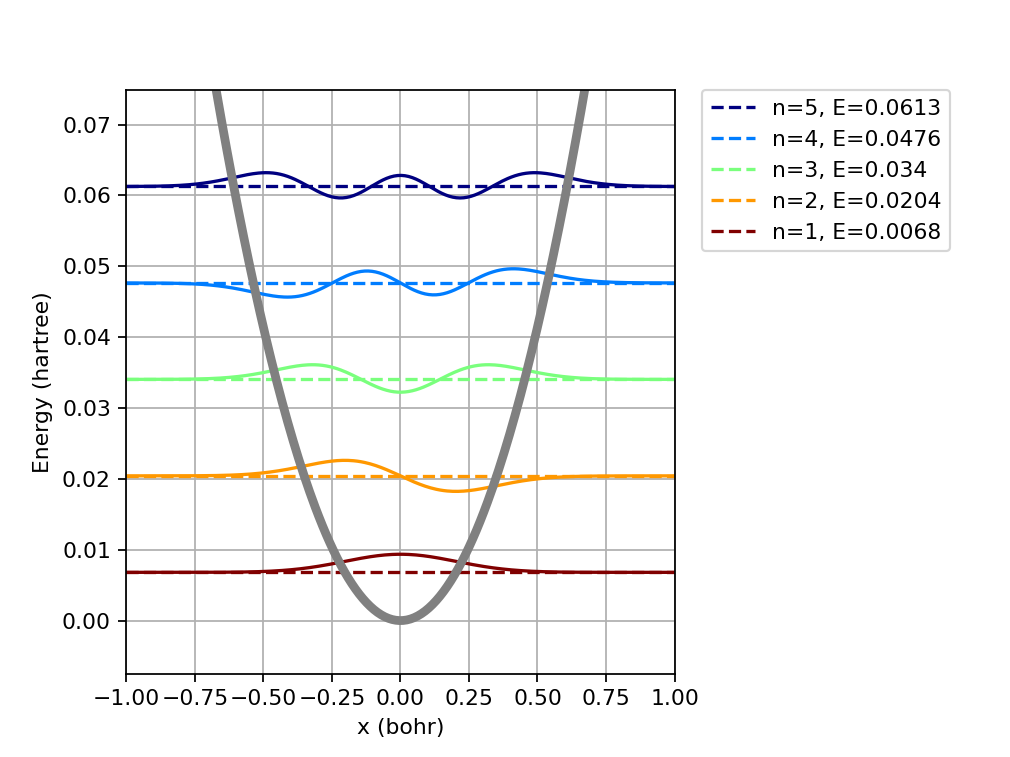

In [17]:
# Create a Laplacian matrix using the 3-point finite-difference method
### BEGIN SOLUTION
Laplacian=(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+np.diag(np.ones(nsteps-1),-1))/dx**2
### END SOLUTION

# Create a harmonic potential energy (Eq. 2) and put those values along the diagonal of a potential energy matrix.
### BEGIN SOLUTION
Varray = 1/2*k*xvec**2
V = AssignQuantity(np.diag(Varray.magnitude),Varray.units)
### END SOLUTION

# Create the Hamiltonian
### BEGIN SOLUTION
Hamiltonian = -0.5*hbar**2/mu*Laplacian + V
Hamiltonian.ito('hartree')
### END SOLUTION

# Diagonalize the Hamiltonian to get eigenfunctions and eigenenergies
### BEGIN SOLUTION
Epsi,psi = spla.eigh(Hamiltonian)
Epsi = AssignQuantity(Epsi,'hartree')
### END SOLUTION

# Specify the number of wavefunctions we want to look at (~5)
### BEGIN SOLUTION
number_of_wavefunctions = 5
### END SOLUTION

# Plot the wavefunctions
PL.plotter(Epsi,psi,xvec,V,number_of_wavefunctions)

### A note about the way these states are assigned quantum numbers. 
In the plot you just made, you'll see that the quantum numbers start with $n=1$. You should be aware, however, that this state *is* the ground state; in the literature (and in the Introduction) this is usually referred to as $\psi_0$ (with energy $E_0$). The next state up is labeled here as $n=2$, but it is referred to as $\psi_1$ (with energy $E_1$) in the literature.

### Making a prediction about an IR spectrum
In the cell below, compute the wavenumber of the transition corresponding to $E_{gap}$, in $cm^{-1}$ (see Eqs. 4 & 5).

In [18]:
### BEGIN SOLUTION
Egap = Epsi[1]-Epsi[0]
wavenum = Egap/(h*c)
print(wavenum.to('1/cm'))
### END SOLUTION

2989.0148617240634 / centimeter


### Pause for analysis
Well, how'd your result line up with respect to Fig. 2? What's your %error (compared to, say, $2943 \ cm^{-1}$?

### BEGIN SOLUTION
The error is about 2%.
### END SOLUTION

### Your turn
In the cell below, repeat the analysis you just carried out, but for a different diatomic molecule. 

1837.4715941070517 electron_mass
64626.865501862405 electron_mass
3473.9505997478013 electron_mass
1.9057395040969387 unified_atomic_mass_unit
k = 0.31498630131570743 electron_mass / atomic_unit_of_time ** 2


/home/instructor/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:601: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = asarray(a, dtype=dtype, order=order)


<IPython.core.display.Javascript object>


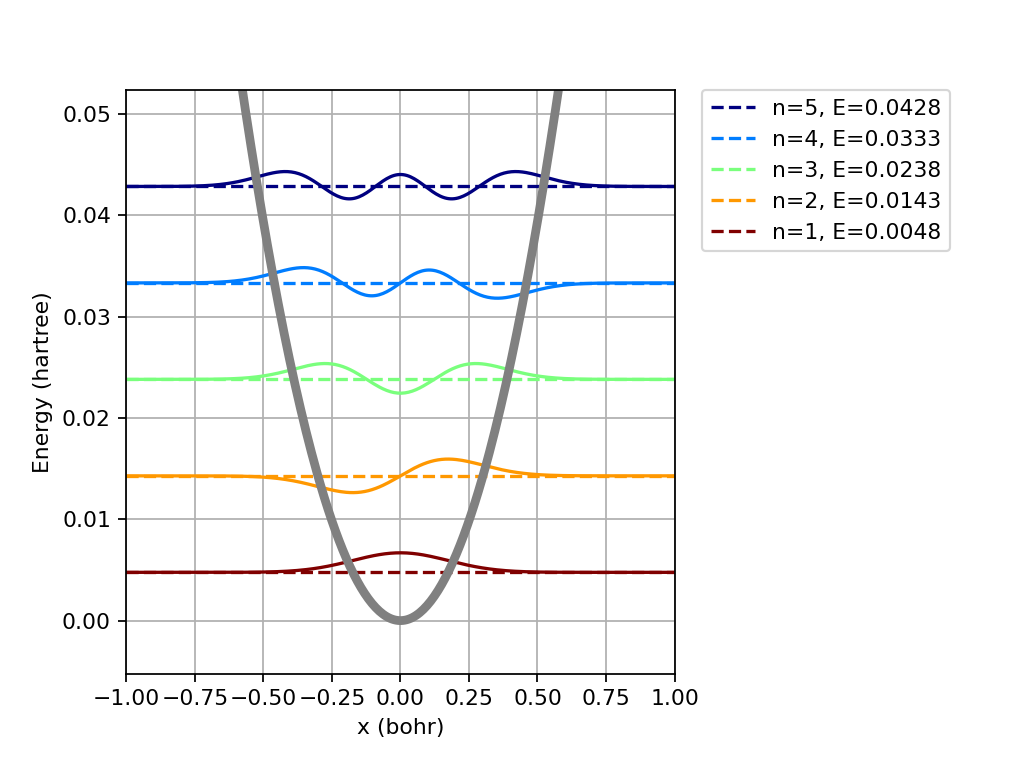

2090.0278656004916 / centimeter


In [19]:
### BEGIN SOLUTION

# This is for DCl (mass of D taken from https://en.wikipedia.org/wiki/Deuterium)
mD = AssignQuantity(2.014,'amu')
mD.ito('atomic_unit_of_mass')
print(mH)

mCl = AssignQuantity(35.453,'amu')
mCl.ito('atomic_unit_of_mass')
print(mCl)

mu = mD*mCl/(mD+mCl)
print(mu)
print(mu.to('amu'))

k = AssignQuantity(4.904e5,'dyne/cm')
k.ito('electron_mass / atomic_unit_of_time**2')
print('k =', k)

# Create a Laplacian matrix using the 3-point finite-difference method
Laplacian=(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+np.diag(np.ones(nsteps-1),-1))/dx**2

# Create a harmonic potential energy (Eq. 2) and put those values along the diagonal of a potential energy matrix.
Varray = 1/2*k*xvec**2
V = AssignQuantity(np.diag(Varray.magnitude),Varray.units)

# Create the Hamiltonian
Hamiltonian = -0.5*hbar**2/mu*Laplacian + V
Hamiltonian.ito('hartree')

# Diagonalize the Hamiltonian yielding the wavefunctions and energies
Epsi,psi = spla.eigh(Hamiltonian)
Epsi = AssignQuantity(Epsi,'hartree')

# Specify the number of wavefunctions we want to look at
number_of_wavefunctions = 5

# Plot the wavefunctions
PL.plotter(Epsi,psi,xvec,V,number_of_wavefunctions)

Egap = Epsi[1]-Epsi[0]
wavenum = Egap/(h*c)
print(wavenum.to('1/cm'))

### END SOLUTION

### Refreshing and saving your code
1. Use the dropdown menu Kernel/Restart
2. Use the dropdown menu Cell/Run All Above
3. Under the "File" dropdown menu item in the upper left is a disk icon. Press it now to save your work (you can, do this at any time as you're working on an assignment, actually).

### Validating
This step will help ensure that you didn't miss something (although it's not a guarantee). Find the "Validate" button and press it. If there are any errors or warnings, fix them.

### Finishing up
Assuming all this has gone smoothly, carry out three more steps (but read this carefully before starting):
1. Close this notebook using the "File/Close and Halt" dropdown menu
1. Using the Assignments tab, submit this notebook
1. Press the Logout tab of the Home Page